# Enhanced Model Complexity

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import glob


# Data Preparation and Loading for Model Training

**Gathering TFRecord Files for Training and Testing Sets**

In [2]:
import glob
train_tfrecord_files = glob.glob('/kaggle/input/tfrecords-dataset/train_tfrecords/*.tfrecord')
test_tfrecord_files = glob.glob('/kaggle/input/tfrecords-dataset/test_tfrecords/*.tfrecord')
# Verify that files are found
print(f"Found {len(train_tfrecord_files)} training TFRecord files")
print(f"Found {len(test_tfrecord_files)} testing TFRecord files")


Found 1440 training TFRecord files
Found 360 testing TFRecord files


**TFRecord Parsing and Dataset Preparation functions definition for Xception Model**

In [6]:
def parse_tfrecord_example(example_proto):
    """
    Parses a single TFRecord example into a formatted example.

    This function takes a serialized TFRecord example and applies a defined schema to parse
    it into a TensorFlow example with a specific structure. It is designed to extract
    the features 'image/encodedrawdata' and 'image/object/class/label' from the input example.

    Parameters:
    - example_proto: A serialized Example to parse.

    Returns:
    - example: A dictionary containing the parsed data of the features defined in the schema.
    """

    # Define the feature description for parsing, which matches the structure of the TFRecord file
    image_feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
        'image/object/class/label': tf.io.FixedLenFeature([], tf.int64),
    }
    # Parse the input serialized TFRecord example according to the defined feature description
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    return example

In [3]:
def load_dataset(tfrecord_files, batch_size=32):
    """
    Load and preprocess a dataset from TFRecord files.

    This function reads TFRecord files, parses the contained examples using the `parse_tfrecord_example` function,
    decodes and resizes the images, and batches the dataset.

    Parameters:
    - tfrecord_files: A list of filepaths to the TFRecord files to load.
    - batch_size: An integer representing the number of items to include in a batch.

    Returns:
    - A `tf.data.Dataset` object representing the loaded and preprocessed dataset ready for training or evaluation.
    """

    # Create a dataset from the list of TFRecord files
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    # Parse each serialized TFRecord example in the dataset
    parsed_dataset = raw_dataset.map(parse_tfrecord_example)
    
    def decode_image_and_resize(feature):
        # Decode the image data from 'image/encodedrawdata' into a tensor and resize it
        image = tf.image.decode_jpeg(feature['image/encodedrawdata'], channels=3)
        image = tf.image.resize(image, [299, 299])  # Resize to the expected input size for the model
        # Extract the label associated with the image
        label = feature['image/object/class/label']
        return image, label
    
    # Apply the decoding and resizing function to each parsed example and batch the dataset
    return parsed_dataset.map(decode_image_and_resize).batch(batch_size)

* I  Chose a batch size of 32 for a balance between efficient GPU memory usage and good model generalization, a common practice in deep learning for image classification.
* I Resized images to 299x299 to match Xception model's expected input size, optimizing for the network's architecture and performance.
* Used channels=3 to convert grayscale images to RGB format, ensuring compatibility with Xception's color image expectations.

**Step 1 : Dividing data into: train, validation, and test sets**

In [4]:
#1. Shuffles the list of training TFRecord files randomly to ensure varied training batches.
np.random.shuffle(train_tfrecord_files)
#2. Determines an 80-20 split for training and validation data
split_size = int(0.8 * len(train_tfrecord_files))
#3. Split the TFRecord files
train_tfrecord_files_split = train_tfrecord_files[:split_size]
val_tfrecord_files_split = train_tfrecord_files[split_size:]

In [7]:
train_dataset = load_dataset(train_tfrecord_files_split)  # Load and preprocess the training dataset
val_dataset = load_dataset(val_tfrecord_files_split)      # Validation data
test_dataset = load_dataset(test_tfrecord_files)          # Test data 


**define the model**

**Reason for Increasing Units to 256:**
* Observed unusual trend: validation accuracy higher than training accuracy, and validation loss lower than training loss.
* Constraint in original task notebook: Required to use only 8 units in the dense layer, limiting adjustments in the original notebook.
* Initial model too simple or over-regularized with only 8 units and 40% dropout, possibly failing to capture complex patterns in the training data.
* Enhancing the model's complexity with 256 units aimed at improving learning of intricate features from the training data.
* Adjustment led to better generalization, reducing the gap between training and validation performance, and ultimately enhancing model performance.


In [8]:
#  thenumber of classes
n_classes = 6  

# Load the base model, Xception
base_model = tf.keras.applications.Xception(
    input_shape=(299, 299, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers in the base model
base_model.trainable = False

# Create the classification model
model = models.Sequential([
    base_model,
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='relu')
])


# Compile the model

model.compile(optimizer="Adam",
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
              metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Implementing a learning rate scheduler to dynamically adjust the learning rate based on validation loss.
* If val_loss doesn't improve for 2 epochs, the learning rate is reduced by a factor of 0.2, with a lower bound set at 1e-3.

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-3,
)

In [12]:
history = model.fit(
    train_dataset,
    steps_per_epoch=16, #each epoch processes 16 batches of data from the training set
    epochs=30, 
    validation_data=val_dataset,
    callbacks=[ reduce_lr]
)


Epoch 1/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 5:14 21s/step - accuracy: 0.1875 - loss: 1.7846

I0000 00:00:1710034253.392821     148 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 436ms/step - accuracy: 0.5237 - loss: 1.2579 - val_accuracy: 0.4132 - val_loss: 3.0715 - learning_rate: 0.0010
Epoch 2/30
 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.8438 - loss: 0.5636

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 226ms/step - accuracy: 0.8545 - loss: 0.4810 - val_accuracy: 0.6771 - val_loss: 1.6512 - learning_rate: 0.0010
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9186 - loss: 0.3156 - val_accuracy: 0.6771 - val_loss: 1.8489 - learning_rate: 0.0010
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9192 - loss: 0.2482 - val_accuracy: 0.7674 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9256 - loss: 0.1960 - val_accuracy: 0.8090 - val_loss: 0.7000 - learning_rate: 0.0010
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9333 - loss: 0.2120 - val_accuracy: 0.7674 - val_loss: 0.8100 - learning_rate: 0.0010
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9670 - loss: 0.1315 - val_accuracy: 0.8542 - val_loss: 0.4861 - learning_rate: 0.0010
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - accuracy: 0.9583 - loss: 0.1310 - val_accuracy:

**Test Accuracy**
* While test accuracy remains consistently high, there is a notable improvement in test loss, decreasing from **0.14** (in Task2_Classification notebook ) to **0.0989**, reflecting a more precise model fit.
* Consistent test accuracy coupled with reduced test loss validates the model enhancements, confirming that increased complexity benefits model performance without sacrificing accuracy.

In [13]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 618ms/step - accuracy: 0.9522 - loss: 0.0998
Test loss: 0.0989, Test accuracy: 0.9639


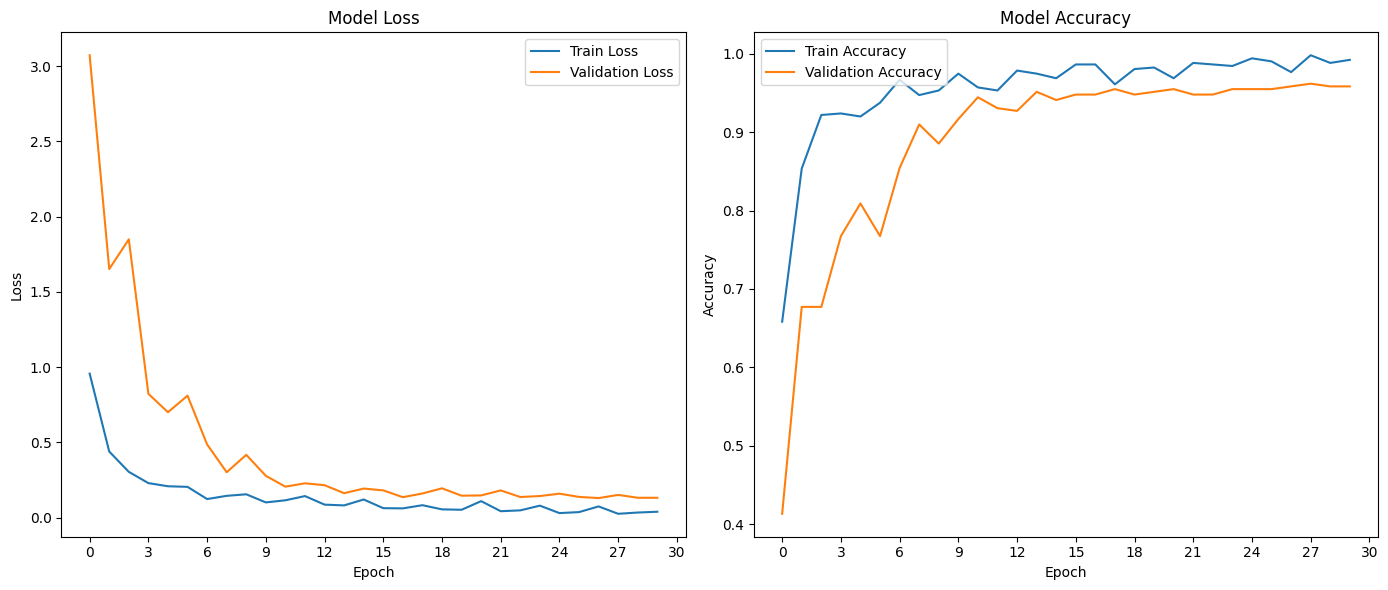

In [14]:

num_epochs = len(history.history['loss'])  # Using the length of the loss array to determine the number of epochs

plt.figure(figsize=(14, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot = Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, num_epochs + 1, max(1, num_epochs // 10)))  # Adjusting x-ticks to accommodate epoch range dynamically
plt.legend(loc="upper right")

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot = Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, num_epochs + 1, max(1, num_epochs // 10)))  
plt.legend(loc="upper left")

plt.tight_layout()  


* The enhanced model complexity has successfully addressed **the initial concern (task2_Classification notebook)** where the validation metrics were outperforming the training metrics.
* Training accuracy has improved and aligned more closely with validation accuracy, suggesting effective learning without overfitting.
* The reduction in the performance gap demonstrates that increasing the model's complexity allowed for more robust feature learning, leading to a balanced and improved generalization.

**Evaluate the model**

In [16]:
test_images, test_labels = next(iter(test_dataset.unbatch().batch(360)))  
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels.numpy()

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Calculate and display the classification report including the F1 score
report = classification_report(true_classes, predicted_classes)
print(report)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.98      0.88      0.93        60
           2       0.97      0.98      0.98        60
           3       0.94      0.97      0.95        60
           4       1.00      1.00      1.00        60
           5       0.92      0.97      0.94        60

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



* The classification report shows a slight improvement across various classes comparing to the original notebook , which indicates that the model is classifying the test data with greater precision

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


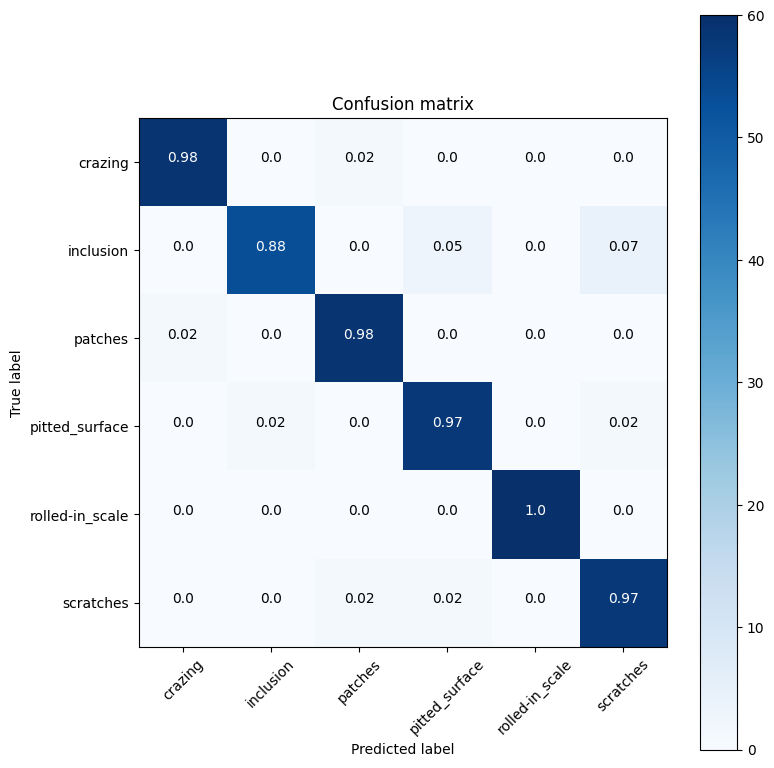

In [17]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_labels.numpy()
cm = confusion_matrix(true_classes, predicted_classes)

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
      cm (array, shape = [n, n]): a confusion matrix of integer classes
      class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    #  white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

class_names = ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches'] 
plot_confusion_matrix(cm, class_names)
plt.show()


In [18]:
tf.saved_model.save(model, 'my_tf_saved_model')

# Inference on TFRecord Test Samples


In [19]:
loaded_model = tf.saved_model.load('my_tf_saved_model')


In [63]:
class_names = {
    0: 'crazing',
    1: 'inclusion',
    2: 'patches',
    3: 'pitted_surface',
    4: 'rolled-in_scale',
    5: 'scratches'
}


In [24]:
def parse_tfrecord_example_for_visualization(example_proto):
    """
Prepares and parses TFRecord examples for model inference and visualization.

This function decodes images stored in serialized TFRecord examples for both feeding them into the model and displaying the original images. 
It decodes the image twice: once for input to the model, resizing it to the model's expected input size, 
and once in its original form for visualization purposes.

Parameters:

example_proto: The serialized TFRecord example to parse.
Returns:

image_for_model: The decoded and resized image tensor for model inference.
image_for_visualization: The decoded image tensor in its original size for visualization.
"""
    image_feature_description = {
        'image/encodedrawdata': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example_proto, image_feature_description)
    
    # Decode the image data for model input
    image_for_model = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    image_for_model = tf.image.resize(image_for_model, [299, 299])
    
    #  decode the original image for visualization
    image_for_visualization = tf.image.decode_jpeg(example['image/encodedrawdata'], channels=3)
    
    return image_for_model, image_for_visualization
  

In [25]:
def load_dataset_for_inference_and_visualization(tfrecord_files, batch_size=1):
    """
Prepares a dataset for model inference and visualization from TFRecord files.

This function loads TFRecord files into a TensorFlow dataset, 
Each TFRecord is processed to yield a pair of image tensors: 
one for input into the model, and one in its original size for visualization.
The dataset is batched, with a default batch size of 1, suitable for inference on individual images.

Parameters:

tfrecord_files: A list of paths to the TFRecord files.
batch_size: The number of items to include in each batch (default is 1 for individual inference).

Returns:

A batched tf.data.Dataset with pairs of tensors for model input and visualization.
"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_files)
    dataset = raw_dataset.map(parse_tfrecord_example_for_visualization)
    return dataset.batch(batch_size)

In [26]:
def softmax(x):
    """
Calculates the softmax of a set of scores in x.

The softmax function converts a vector of numbers into a vector of probabilities,
where the probabilities of each value are proportional to the exponential of the original values. 

Parameters:

x: An array of scores to be converted into probabilities.

Returns:

An array of the same shape as x representing normalized softmax probabilities.
"""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

In [ ]:
tfrecord_file_for_inference = ['/kaggle/input/tfrecords-samples-for-inference/rolled-in_scale_rolled-in_scale_256.jpg.tfrecord']
test_dataset = load_dataset_for_inference_and_visualization(tfrecord_file_for_inference, batch_size=1)

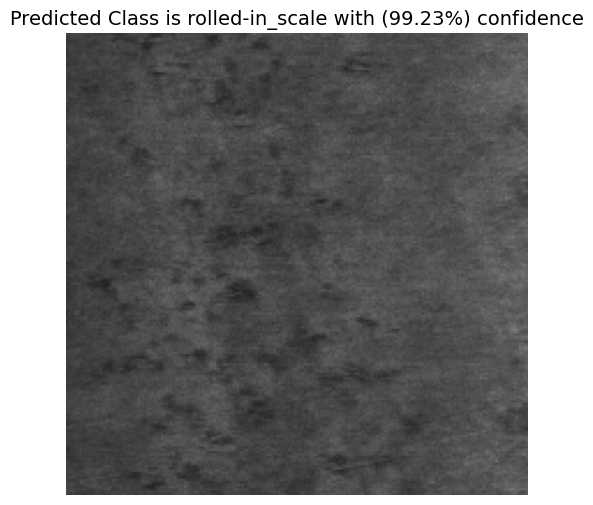

In [27]:
for image_batch, image_visualization_batch in test_dataset:
    predictions = loaded_model.signatures['serving_default'](inputs=tf.constant(image_batch, dtype=tf.float32))
    predicted_scores = predictions['output_0'].numpy()  # 'output_0' is the model output name
    probabilities = softmax(predicted_scores)  # Compute softmax to get probabilities
    predicted_labels = np.argmax(predicted_scores, axis=1)
    max_probabilities = np.max(probabilities, axis=1) * 100  # Convert to percentage

    # Translate numeric labels into meaningful class names and add prediction confidence
    predicted_class_names_with_confidence = [
        f"Predicted Class is {class_names[label]} with ({confidence:.2f}%) confidence" for label, confidence in zip(predicted_labels, max_probabilities)
    ]

    # Visualization
    for image_visualization, predicted_class_name_with_confidence in zip(image_visualization_batch, predicted_class_names_with_confidence):
        plt.figure(figsize=(6, 6))
        plt.imshow(image_visualization.numpy().astype("uint8"))
        plt.title(predicted_class_name_with_confidence, fontsize=14)  # Display class with confidence (expected :rolled-in_scale) 
        plt.axis('off')
        plt.show()

In [28]:
tfrecord_files_for_inference = ['/kaggle/input/tfrecords-samples-for-inference/rolled-in_scale_rolled-in_scale_256.jpg.tfrecord',
                               '/kaggle/input/tfrecords-samples-for-inference/pitted_surface_pitted_surface_277.jpg.tfrecord',
                               '/kaggle/input/tfrecords-samples-for-inference/scratches_scratches_270.jpg.tfrecord',
                               '/kaggle/input/tfrecords-samples-for-inference/patches_patches_285.jpg.tfrecord'
                              ]

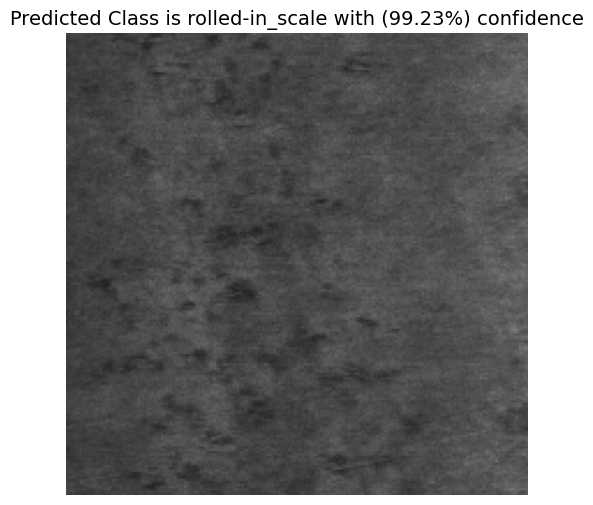

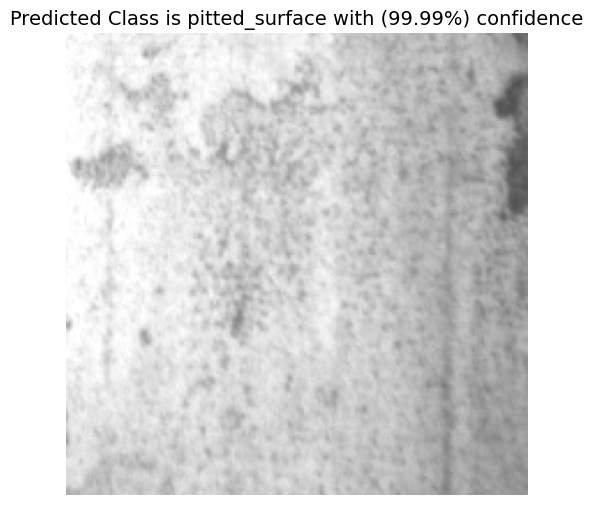

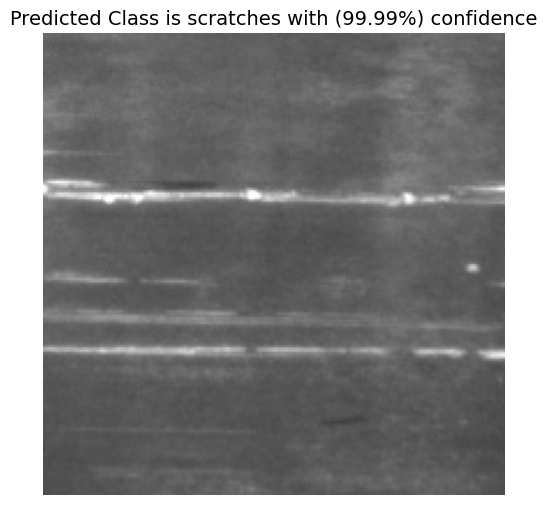

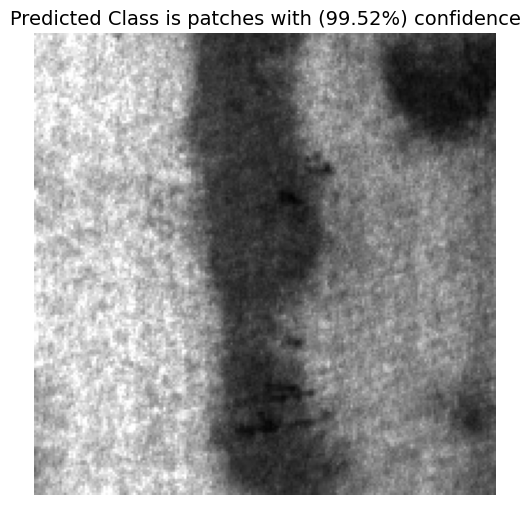

In [29]:
test_dataset = load_dataset_for_inference_and_visualization(tfrecord_files_for_inference, batch_size=1)


for image_batch, image_visualization_batch in test_dataset:
    predictions = loaded_model.signatures['serving_default'](inputs=tf.constant(image_batch, dtype=tf.float32))
    predicted_scores = predictions['output_0'].numpy()  # 'output_0' is the model output name
    probabilities = softmax(predicted_scores)  # Compute softmax to get probabilities
    predicted_labels = np.argmax(predicted_scores, axis=1)
    max_probabilities = np.max(probabilities, axis=1) * 100  # Convert to percentage

    # Translate numeric labels into meaningful class names and add prediction confidence
    predicted_class_names_with_confidence = [
        f"Predicted Class is {class_names[label]} with ({confidence:.2f}%) confidence" for label, confidence in zip(predicted_labels, max_probabilities)
    ]

    # Visualization
    for image_visualization, predicted_class_name_with_confidence in zip(image_visualization_batch, predicted_class_names_with_confidence):
        plt.figure(figsize=(6, 6))
        plt.imshow(image_visualization.numpy().astype("uint8"))
        plt.title(predicted_class_name_with_confidence, fontsize=14)  # Display class name with confidence
        plt.axis('off')
        plt.show()
